# Is there a Converging Sampling Distribution in Machine Learning Performance metrics?
**Fabian Juarez, Surya Sama**
- [Project proposal](https://github.com/samasurya/Research-Projects-and-Predictive-Models/blob/ML-ECON-GA-4005-Project/Machine_Learning_Project_Proposal.pdf)
- [Data report](https://github.com/samasurya/Research-Projects-and-Predictive-Models/blob/ML-ECON-GA-4005-Project/Data%20Report.pdf)

In [401]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import pipeline, linear_model, preprocessing, model_selection, metrics
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from scipy.stats import shapiro
import scipy.stats as stats
import pylab

In [450]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import Flatten

## Defining the necessary functions used in the bootstrapping procedure, and to plot and analyze the data we gather.

## Classification Problem:
We are trying to classify the survival status of 809 passengers who travelled aboard Titanic based on the details like Age, Sex, Fare,etc.

## Models:
- Logistic Regression
- Random Forests
- One - Layer MLP

## Metrics:
- Accuracy score
- Brier score
- ROC - AUC score
- Log loss

In [560]:
def model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    acc_train = metrics.accuracy_score(y_train, model.predict(X_train))
    acc_test = metrics.accuracy_score(y_test, model.predict(X_test))
    brier_train = metrics.brier_score_loss(y_train, model.predict_proba(X_train)[:,1])
    brier_test = metrics.brier_score_loss(y_test, model.predict_proba(X_test)[:,1])
    roc_train = metrics.roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    roc_test = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    logloss_train = metrics.log_loss(y_train, model.predict_proba(X_train)[:,1])
    logloss_test = metrics.log_loss(y_test, model.predict_proba(X_test)[:,1])
    train_scores = [acc_train, brier_train, roc_train, logloss_train]
    test_scores = [acc_test, brier_test, roc_test, logloss_test]
    return train_scores, test_scores

The model() function is used in the bootstrapping procedure to fit the required model and collect the necessary metrics used in the analysis. This function returns 2 lists which record the traing scores and testing scores of the model.

In [553]:
def metricsplots(train, test, k, p): #k = number of columns, p = plots
    fig, axs = plt.subplots(1, k, figsize = (20,5))
    end = 1
    for jj in range(k):
        if (end > p): 
            axs[jj].set_visible(False)
            break
        axs[jj].hist(test.iloc[:,end-1], bins = 30, label = 'test')
        axs[jj].vlines(np.mean(test.iloc[:, end-1]), 0 , 100, label = 'avg. test', color = 'red')
        axs[jj].hist(train.iloc[:,end-1], bins = 30, label = "train", alpha = 0.75)
        axs[jj].vlines(np.mean(train.iloc[:, end-1]), 0 , 100, label = 'avg. train', color = 'black')
        axs[jj].set_title(train.columns[end-1])
        axs[jj].legend()
        end = end + 1

The metricsplots() function is used to plot the histograms of the train and test metrics to visually inspect the distribution of the performance metrics gathered from the bootstrapping procedure.

In [554]:
def normtest(df): 
    p_vals = []
    statistics = []
    metrics = []
    reject_null = []
    mean_metric = []
    median_metric = []
    Normal = []
    for column in df:
        metrics.append(column)
        p_vals.append(shapiro(df[column])[1])
        statistics.append(shapiro(df[column])[0])
        mean_metric.append(df[column].mean())
        median_metric.append(df[column].median())
        if shapiro(df[column])[1] < 0.05:
            reject_null.append(1)
            Normal.append('NO')
        else:
            reject_null.append(0)
            Normal.append('YES')
    return pd.DataFrame(list(zip(metrics, p_vals, statistics, reject_null, mean_metric, median_metric, Normal)), columns = ['Metric', 'P_Value', 'Stat', 'reject_null', 'Mean', 'Median','Normal'])    

The normtest() function is used to test the null hypothesis that the data is normally distributed. This function conducts the Shapiro-Wilk test for Normality for all the performance metrics we amass. This function returns a summary dataframe of the results of the test and some summaries regarding the performance metrics.

In [555]:
def compareplots(reg, neural, forest, title = '% training size'):#insert reg, then neural then forest
    fig, axs = plt.subplots(2, 2, figsize = (20,10))
    end = 1
    for ii in range(2):
        for jj in range(2):
            axs[ii,jj].hist(reg.iloc[:,end-1], bins = 30, label = 'OLS')
            axs[ii,jj].vlines(np.mean(reg.iloc[:, end-1]), 0 , 100, label = 'avg. OLS', color = 'red')
            axs[ii,jj].hist(neural.iloc[:,end-1], bins = 30, label = "NN", alpha = 0.75)
            axs[ii,jj].vlines(np.mean(neural.iloc[:, end-1]), 0 , 100, label = 'avg. NN', color = 'black')
            axs[ii,jj].hist(forest.iloc[:,end-1], bins = 30, label = "RF", alpha = 0.75)
            axs[ii,jj].vlines(np.mean(forest.iloc[:, end-1]), 0 , 100, label = 'avg. RF', color = 'green')
            axs[ii,jj].set_title(forest.columns[end-1])
            axs[ii,jj].legend()
            end = end + 1
    fig.suptitle(title)

The compareplots() function is used to plot the histograms/distributions of all the performance metrics for all the three Models for a given training size. 

In [627]:
def meantests(reg, neural, forest, alpha):
    p_vals = []
    metrics = []
    statistics = []
    different = []
    for column in reg:
        f,p = stats.f_oneway(reg[column],neural[column],forest[column])
        p_vals.append(p)
        statistics.append(f)
        metrics.append(column)
        if p < alpha:
            different.append("YES")
        else:
            different.append("NO")
    final = pd.DataFrame(list(zip(metrics, p_vals, statistics, different)), 
                         columns = ["Metric", "p", 'ANOVA Statistic', "Different Means"] )
    return final

We want to compare the means of the performance metrics of the three models. To compare the means we would like to use the one-way ANOVA test. So the meantests() functions does exactly this and returns us a dataframe that describes the results of the test.

## Loading the Titanic dataset

In [407]:
titanic = pd.read_csv(r"C:\Users\samas\OneDrive\Desktop\Machine Learning Project\Titanic\titanic.csv")
X = titanic.drop(['Survived','Unnamed: 0', 'Passengerid','FareBand'], axis = 1)
y = titanic['Survived']

## We decided to stick to 3 Training sizes which are 0.5, 0.75, and 0.9 for our analysis.

### Logistic Regression Training size 0.5

## Bootstrapping Procedure:
We designed a for loop to conduct our bootstrapping procedure to gather the performance metrics by running the model 1000 times.

In [561]:
train_metrics_0 = []
test_metrics_0 = []
for i in range(1000):
    df = titanic.sample(frac = 1, replace = True)
    X = df.drop(['Survived','Unnamed: 0', 'Passengerid','FareBand'], axis = 1)
    y = df['Survived']
    split = model_selection.train_test_split(X, y, train_size= 0.5)
    X_train, X_test, y_train, y_test = split
    mets = model(X_train, y_train, X_test, y_test, LogisticRegression())
    train_metrics_0.append(mets[0])
    test_metrics_0.append(mets[1])

In [564]:
train_df_0 = pd.DataFrame(train_metrics_0, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss']) 
test_df_0 = pd.DataFrame(test_metrics_0, columns = ['accuracy','brier', 'roc_auc', 'log_loss'])

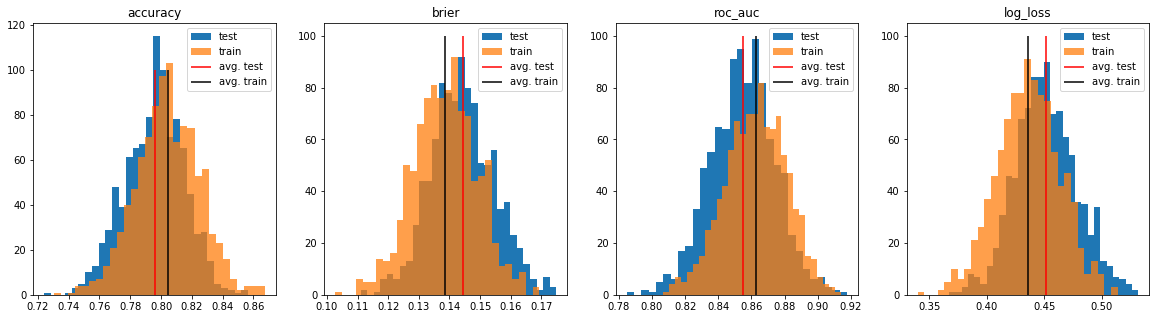

In [566]:
metricsplots(train_df_0, test_df_0, 4,4)

In [567]:
normtest(train_df_0)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.112720,0.997413,0,0.804180,0.804494,YES
1,brier,0.708717,0.998730,0,0.138597,0.138554,YES
2,roc_auc,0.030403,0.996619,1,0.862535,0.863239,NO
3,log_loss,0.689028,0.998701,0,0.435929,0.436041,YES


In [568]:
normtest(test_df_0)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.004766,0.995483,1,0.795796,0.798206,NO
1,brier,0.106642,0.997379,0,0.144269,0.143700,YES
2,roc_auc,0.783432,0.998845,0,0.854763,0.854877,YES
3,log_loss,0.077818,0.997187,0,0.451617,0.450142,YES


### Logistic Regression Training size 0.75

In [569]:
train_metrics_1 = []
test_metrics_1 = []
for i in range(1000):
    df = titanic.sample(frac = 1, replace = True)
    X = df.drop(['Survived','Unnamed: 0', 'Passengerid','FareBand'], axis = 1)
    y = df['Survived']
    split = model_selection.train_test_split(X, y, train_size= 0.75)
    X_train, X_test, y_train, y_test = split
    mets = model(X_train, y_train, X_test, y_test, LogisticRegression())
    train_metrics_1.append(mets[0])
    test_metrics_1.append(mets[1])

In [570]:
train_df_1 = pd.DataFrame(train_metrics_1, columns = ['accuracy','brier', 'roc_auc', 'log_loss']) 
test_df_1 = pd.DataFrame(test_metrics_1, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss'])

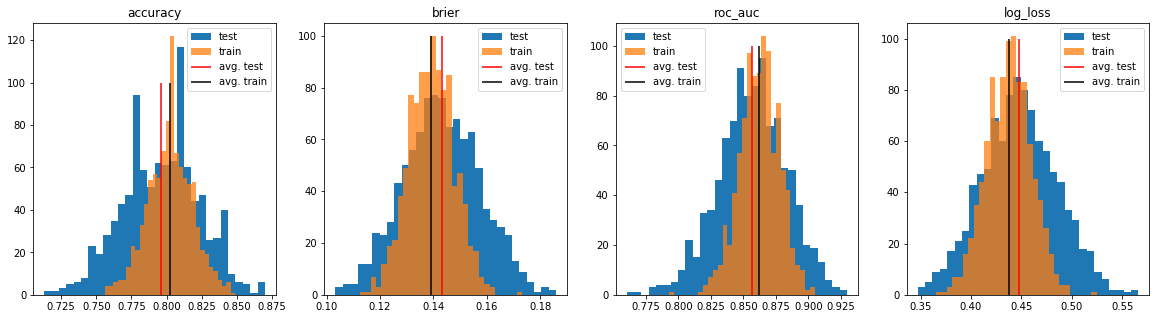

In [571]:
metricsplots(train_df_1, test_df_1, 4,4)

In [572]:
normtest(train_df_1)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.294538,0.998028,0,0.802440,0.802395,YES
1,brier,0.805371,0.998880,0,0.139206,0.139245,YES
2,roc_auc,0.012386,0.996075,1,0.862272,0.862778,NO
3,log_loss,0.822403,0.998908,0,0.437554,0.438404,YES


In [573]:
normtest(test_df_1)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.004373,0.995429,1,0.796031,0.798206,NO
1,brier,0.543615,0.998483,0,0.143033,0.142723,YES
2,roc_auc,0.072833,0.997147,0,0.856849,0.857338,YES
3,log_loss,0.518900,0.998444,0,0.447987,0.447035,YES


### Logistic Regression Training size 0.9

In [574]:
train_metrics_2 = []
test_metrics_2 = []
for i in range(1000):
    df = titanic.sample(frac = 1, replace = True)
    X = df.drop(['Survived','Unnamed: 0', 'Passengerid','FareBand'], axis = 1)
    y = df['Survived']
    split = model_selection.train_test_split(X, y, train_size= 0.9)
    X_train, X_test, y_train, y_test = split
    mets = model(X_train, y_train, X_test, y_test, LogisticRegression())
    train_metrics_2.append(mets[0])
    test_metrics_2.append(mets[1])

In [575]:
train_df_2 = pd.DataFrame(train_metrics_2, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss']) 
test_df_2 = pd.DataFrame(test_metrics_2, columns = ['accuracy',  'brier', 'roc_auc', 'log_loss'])

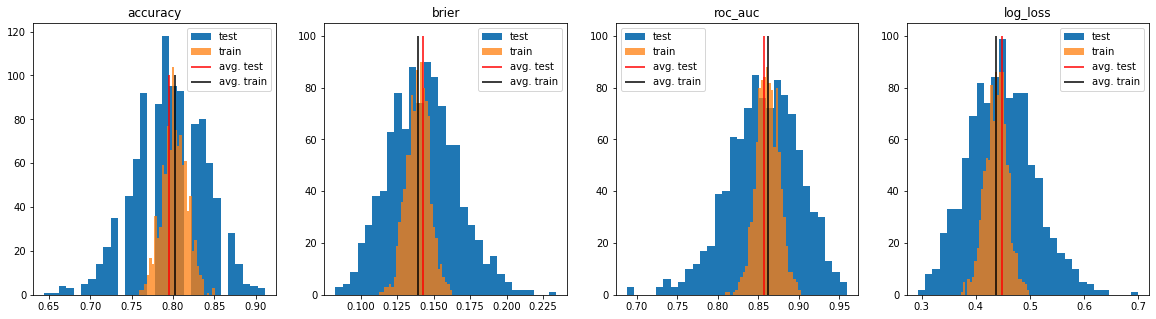

In [576]:
metricsplots(train_df_2, test_df_2,4,4)

In [577]:
normtest(train_df_2)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.359230,0.998166,0,0.802040,0.801498,YES
1,brier,0.305964,0.998054,0,0.139335,0.139589,YES
2,roc_auc,0.645999,0.998637,0,0.861510,0.861258,YES
3,log_loss,0.140309,0.997549,0,0.437950,0.438752,YES


In [578]:
normtest(test_df_2)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.000008,0.990977,1,0.795367,0.800000,NO
1,brier,0.004457,0.995441,1,0.142862,0.142852,NO
2,roc_auc,0.000004,0.990451,1,0.857110,0.858511,NO
3,log_loss,0.000617,0.994155,1,0.447705,0.445380,NO


### Random Forest Classifier Training size 0.5

In [579]:
train_metrics_rf_0 = []
test_metrics_rf_0 = []
for i in range(1000):
    df = titanic.sample(frac = 1, replace = True)
    X = df.drop(['Survived','Unnamed: 0', 'Passengerid','FareBand'], axis = 1)
    y = df['Survived']
    split = model_selection.train_test_split(X, y, train_size= 0.5)
    X_train, X_test, y_train, y_test = split
    mets = model(X_train, y_train, X_test, y_test, RandomForestClassifier(max_depth = 5, min_samples_leaf= 15))
    train_metrics_rf_0.append(mets[0])
    test_metrics_rf_0.append(mets[1])

In [580]:
train_df_rf_0 = pd.DataFrame(train_metrics_rf_0, columns = ['accuracy',  'brier', 'roc_auc', 'log_loss']) 
test_df_rf_0 = pd.DataFrame(test_metrics_rf_0, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss'])

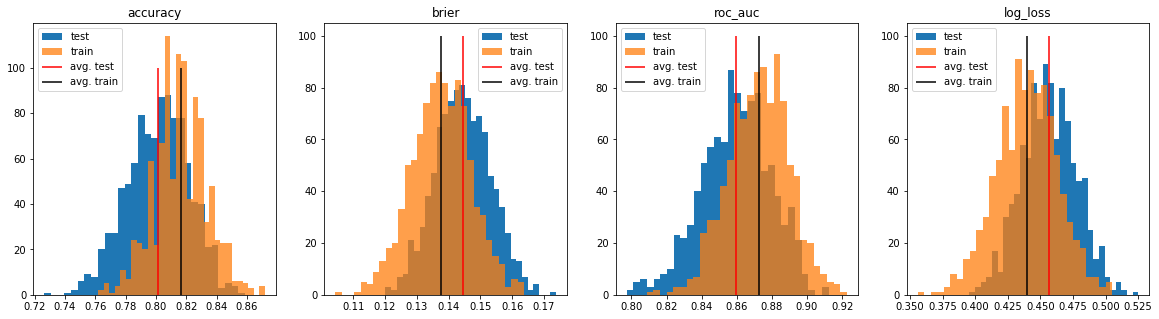

In [581]:
metricsplots(train_df_rf_0, test_df_rf_0,4,4)

In [582]:
normtest(train_df_rf_0)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.081467,0.997215,0,0.816429,0.815730,YES
1,brier,0.867763,0.998990,0,0.137691,0.137869,YES
2,roc_auc,0.082538,0.997223,0,0.872543,0.873187,YES
3,log_loss,0.653158,0.998648,0,0.439641,0.440358,YES


In [583]:
normtest(test_df_rf_0)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.005392,0.995561,1,0.801578,0.802691,NO
1,brier,0.817470,0.998900,0,0.144493,0.144358,YES
2,roc_auc,0.000316,0.993698,1,0.859594,0.860192,NO
3,log_loss,0.870147,0.998994,0,0.456577,0.456300,YES


### Random Forest Classifier Training size 0.75

In [584]:
train_metrics_rf_1 = []
test_metrics_rf_1 = []
for i in range(1000):
    df = titanic.sample(frac = 1, replace = True)
    X = df.drop(['Survived','Unnamed: 0', 'Passengerid','FareBand'], axis = 1)
    y = df['Survived']
    split = model_selection.train_test_split(X, y, train_size= 0.75)
    X_train, X_test, y_train, y_test = split
    mets = model(X_train, y_train, X_test, y_test, RandomForestClassifier(max_depth = 5, min_samples_leaf= 15))
    train_metrics_rf_1.append(mets[0])
    test_metrics_rf_1.append(mets[1])

In [585]:
train_df_rf_1 = pd.DataFrame(train_metrics_rf_1, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss']) 
test_df_rf_1 = pd.DataFrame(test_metrics_rf_1, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss'])

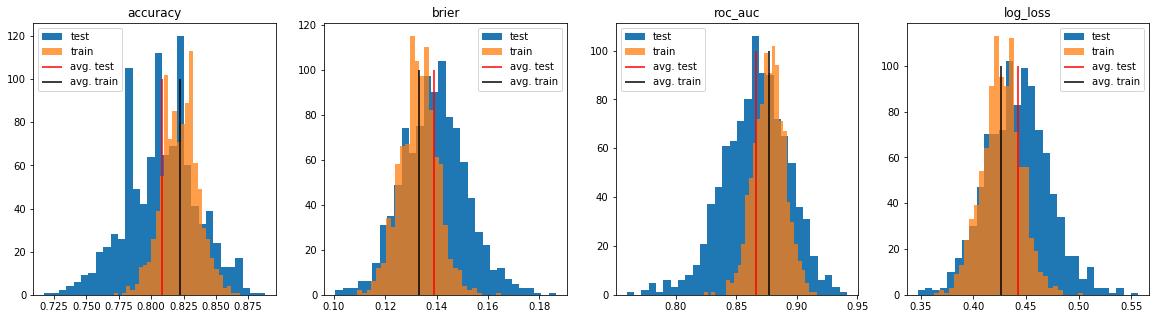

In [586]:
metricsplots(train_df_rf_1, test_df_rf_1,4,4)

In [587]:
normtest(train_df_rf_1)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.292601,0.998023,0,0.822115,0.821856,YES
1,brier,0.099586,0.997337,0,0.133068,0.133180,YES
2,roc_auc,0.197736,0.997765,0,0.877228,0.877599,YES
3,log_loss,0.292754,0.998024,0,0.426701,0.426760,YES


In [588]:
normtest(test_df_rf_1)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.008471,0.995841,1,0.808238,0.807175,NO
1,brier,0.109852,0.997397,0,0.139170,0.139069,YES
2,roc_auc,0.000017,0.991531,1,0.865945,0.867102,NO
3,log_loss,0.078395,0.997191,0,0.442033,0.442038,YES


### Random Forest Classifier Training size 0.9

In [589]:
train_metrics_rf_2 = []
test_metrics_rf_2 = []
for i in range(1000):
    df = titanic.sample(frac = 1, replace = True)
    X = df.drop(['Survived','Unnamed: 0', 'Passengerid','FareBand'], axis = 1)
    y = df['Survived']
    split = model_selection.train_test_split(X, y, train_size= 0.9)
    X_train, X_test, y_train, y_test = split
    mets = model(X_train, y_train, X_test, y_test, RandomForestClassifier(max_depth = 5, min_samples_leaf= 15))
    train_metrics_rf_2.append(mets[0])
    test_metrics_rf_2.append(mets[1])

In [590]:
train_df_rf_2 = pd.DataFrame(train_metrics_rf_2, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss']) 
test_df_rf_2 = pd.DataFrame(test_metrics_rf_2, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss'])

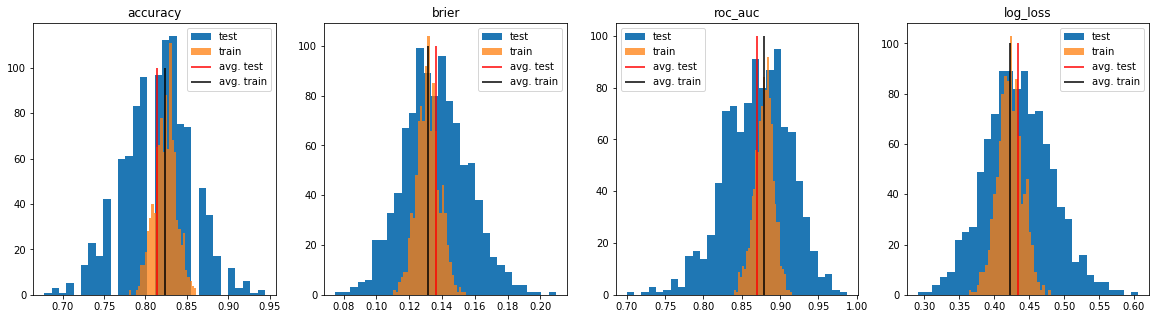

In [591]:
metricsplots(train_df_rf_2, test_df_rf_2,4,4)

In [592]:
normtest(train_df_rf_2)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.058240,0.997011,0,0.823959,0.823970,YES
1,brier,0.613045,0.998588,0,0.131576,0.131441,YES
2,roc_auc,0.003607,0.995308,1,0.878862,0.879640,NO
3,log_loss,0.684735,0.998694,0,0.422427,0.422474,YES


In [593]:
normtest(test_df_rf_2)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.000044,0.992275,1,0.814233,0.811111,NO
1,brier,0.432906,0.998302,0,0.136091,0.135744,YES
2,roc_auc,0.000057,0.992466,1,0.870274,0.872354,NO
3,log_loss,0.330518,0.998107,0,0.434181,0.432481,YES


### Keras Sequential MLP

In [594]:
def network():
    # create model
    model = Sequential()
    model.add(Dense(20, activation='relu', input_shape = (6,)))
    model.add(Dense(2, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['BinaryAccuracy'])
    return model
network = network()

Buliding the Multi-Layered Perceptron with one hidden layer and 20 neurons.

In [595]:
tf.data.experimental.enable_debug_mode() #activating debug mode to build a function that underlies keras  model

In [596]:
def mlp(X_train, y_train, X_test, y_test):
    y_nn = tf.keras.utils.to_categorical(y_train)
    network.fit(X_train, y_nn)
    preds_train = network.predict(X_train)
    preds_binary_train = []
    for i in preds_train:
        if i[0] < i[1]:
            preds_binary_train.append(1)
        else:
            preds_binary_train.append(0)
    
    preds_test = network.predict(X_test)
    preds_binary_test = []
    for j in preds_test:
        if j[0] < j[1]:
            preds_binary_test.append(1)
        else:
            preds_binary_test.append(0)
    acc_train = metrics.accuracy_score(y_train, preds_binary_train)
    acc_test = metrics.accuracy_score(y_test, preds_binary_test)
    brier_train = metrics.brier_score_loss(y_train, preds_train[:,1])
    brier_test = metrics.brier_score_loss(y_test, preds_test[:,1])
    roc_train = metrics.roc_auc_score(y_train, preds_train[:,1])
    roc_test = metrics.roc_auc_score(y_test, preds_test[:,1])
    logloss_train = metrics.log_loss(y_train, preds_train[:,1])
    logloss_test = metrics.log_loss(y_test, preds_test[:,1])
    train_scores = [acc_train, brier_train, roc_train, logloss_train]
    test_scores = [acc_test, brier_test, roc_test, logloss_test]
    return train_scores, test_scores

Defining a function to run MLP and predict the probabilities, binary output, and compute the performance metrics. 

### MLP Classifier Training size 0.5

In [597]:
train_metrics_mlp_0 = []
test_metrics_mlp_0 = []
for i in range(1000):
    df = titanic.sample(frac = 1, replace = True)
    X = df.drop(['Survived','Unnamed: 0', 'Passengerid','FareBand'], axis = 1)
    y = df['Survived']
    split = model_selection.train_test_split(X, y, train_size= 0.5)
    X_train, X_test, y_train, y_test = split
    mets = mlp(X_train, y_train, X_test, y_test)
    train_metrics_mlp_0.append(mets[0])
    test_metrics_mlp_0.append(mets[1])

14/14 [==============================] - 0s 30ms/step - loss: 0.3903 - binary_accuracy: 0.8348


14/14 [==============================] - 0s 31ms/step - loss: 0.4485 - binary_accuracy: 0.7966


14/14 [==============================] - 0s 34ms/step - loss: 0.4179 - binary_accuracy: 0.8180


14/14 [==============================] - 0s 22ms/step - loss: 0.3989 - binary_accuracy: 0.8348


14/14 [==============================] - 0s 21ms/step - loss: 0.3728 - binary_accuracy: 0.8494


14/14 [==============================] - 0s 24ms/step - loss: 0.3780 - binary_accuracy: 0.8213


In [598]:
train_df_mlp_0 = pd.DataFrame(train_metrics_mlp_0, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss']) 
test_df_mlp_0 = pd.DataFrame(test_metrics_mlp_0, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss'])

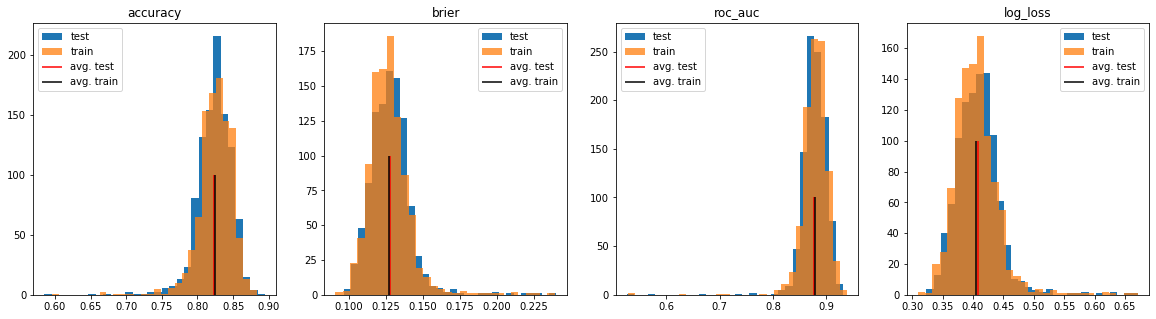

In [599]:
metricsplots(train_df_mlp_0, test_df_mlp_0,4,4)

In [600]:
normtest(train_df_mlp_0)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,1.292124e-27,0.874451,1,0.825085,0.826966,NO
1,brier,1.831118e-29,0.853439,1,0.127176,0.126029,NO
2,roc_auc,7.516188e-39,0.699906,1,0.878588,0.880820,NO
3,log_loss,6.239793e-27,0.881601,1,0.405121,0.402216,NO


In [601]:
normtest(test_df_mlp_0)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,6.212140e-26,0.891466,1,0.823581,0.825112,NO
1,brier,3.214334e-28,0.867860,1,0.128229,0.127740,NO
2,roc_auc,8.912628e-38,0.722152,1,0.877305,0.878466,NO
3,log_loss,1.717563e-25,0.895625,1,0.408189,0.406671,NO


### MLP Classifier Training size 0.75

In [602]:
train_metrics_mlp_1 = []
test_metrics_mlp_1 = []
for i in range(1000):
    df = titanic.sample(frac = 1, replace = True)
    X = df.drop(['Survived','Unnamed: 0', 'Passengerid','FareBand'], axis = 1)
    y = df['Survived']
    split = model_selection.train_test_split(X, y, train_size= 0.75)
    X_train, X_test, y_train, y_test = split
    mets = mlp(X_train, y_train, X_test, y_test)
    train_metrics_mlp_1.append(mets[0])
    test_metrics_mlp_1.append(mets[1])

21/21 [==============================] - 0s 21ms/step - loss: 0.3856 - binary_accuracy: 0.8263


21/21 [==============================] - 0s 22ms/step - loss: 0.3955 - binary_accuracy: 0.8166


21/21 [==============================] - 0s 23ms/step - loss: 0.3666 - binary_accuracy: 0.8413


21/21 [==============================] - 0s 23ms/step - loss: 0.4018 - binary_accuracy: 0.8181


21/21 [==============================] - 0s 23ms/step - loss: 0.4010 - binary_accuracy: 0.8286


21/21 [==============================] - 0s 23ms/step - loss: 0.4036 - binary_accuracy: 0.8249


In [603]:
train_df_mlp_1 = pd.DataFrame(train_metrics_mlp_1, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss']) 
test_df_mlp_1 = pd.DataFrame(test_metrics_mlp_1, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss'])

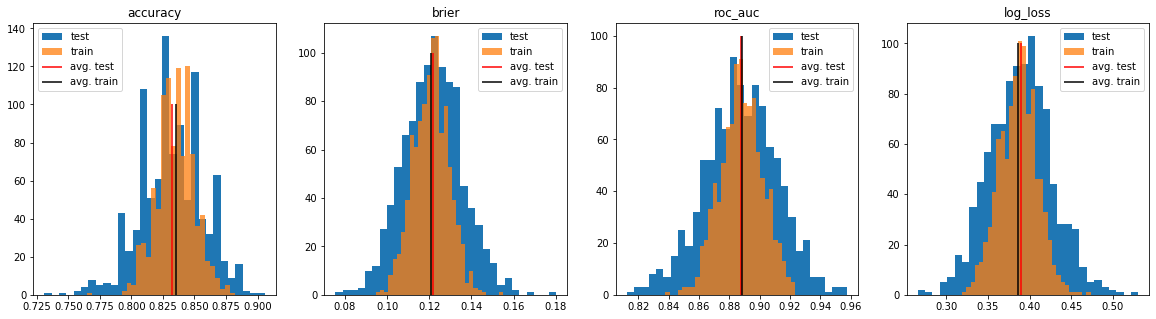

In [604]:
metricsplots(train_df_mlp_1, test_df_mlp_1,4,4)

In [605]:
normtest(train_df_mlp_1)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.010051,0.995947,1,0.834957,0.835329,NO
1,brier,0.533247,0.998467,0,0.120854,0.121241,YES
2,roc_auc,0.177440,0.997696,0,0.888012,0.887713,YES
3,log_loss,0.425479,0.998289,0,0.386614,0.387592,YES


In [606]:
normtest(test_df_mlp_1)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.000452,0.993943,1,0.831807,0.834081,NO
1,brier,0.591541,0.998556,0,0.121764,0.122129,YES
2,roc_auc,0.369242,0.998186,0,0.887456,0.887482,YES
3,log_loss,0.563451,0.998513,0,0.389123,0.389953,YES


### MLP Classifier Training size 0.9

In [607]:
train_metrics_mlp_2 = []
test_metrics_mlp_2 = []
for i in range(1000):
    df = titanic.sample(frac = 1, replace = True)
    X = df.drop(['Survived','Unnamed: 0', 'Passengerid','FareBand'], axis = 1)
    y = df['Survived']
    split = model_selection.train_test_split(X, y, train_size= 0.9)
    X_train, X_test, y_train, y_test = split
    mets = mlp(X_train, y_train, X_test, y_test)
    train_metrics_mlp_2.append(mets[0])
    test_metrics_mlp_2.append(mets[1])

26/26 [==============================] - 1s 21ms/step - loss: 0.3700 - binary_accuracy: 0.8471


26/26 [==============================] - 1s 28ms/step - loss: 0.3737 - binary_accuracy: 0.8377


26/26 [==============================] - 1s 25ms/step - loss: 0.3557 - binary_accuracy: 0.8533


26/26 [==============================] - 1s 28ms/step - loss: 0.3671 - binary_accuracy: 0.8258


26/26 [==============================] - 1s 29ms/step - loss: 0.3417 - binary_accuracy: 0.8477


26/26 [==============================] - 1s 40ms/step - loss: 0.3881 - binary_accuracy: 0.8358


In [608]:
train_df_mlp_2 = pd.DataFrame(train_metrics_mlp_2, columns = ['accuracy', 'brier', 'roc_auc', 'log_loss']) 
test_df_mlp_2 = pd.DataFrame(test_metrics_mlp_2, columns = ['accuracy','brier', 'roc_auc', 'log_loss'])

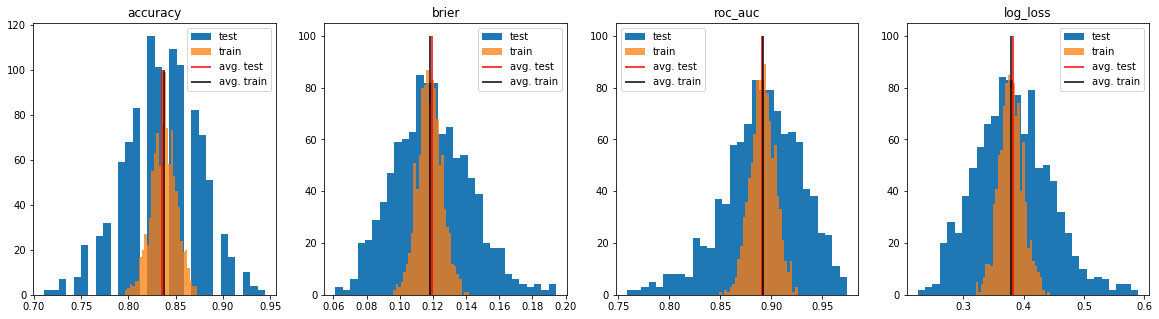

In [609]:
metricsplots(train_df_mlp_2, test_df_mlp_2,4,4)

In [610]:
normtest(train_df_mlp_2)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,0.041268,0.996804,1,0.837509,0.837703,NO
1,brier,0.837944,0.998935,0,0.118217,0.117971,YES
2,roc_auc,0.918481,0.999097,0,0.891593,0.891558,YES
3,log_loss,0.589548,0.998553,0,0.378988,0.378609,YES


In [626]:
normtest(test_df_mlp_2)

,Metric,P_Value,Stat,reject_null,Mean,Median,Normal
0,accuracy,8.994582e-06,0.991041,1,0.835056,0.833333,NO
1,brier,3.001630e-04,0.993662,1,0.119287,0.118041,NO
2,roc_auc,1.147901e-08,0.984858,1,0.891131,0.893035,NO
3,log_loss,3.107027e-05,0.992011,1,0.381829,0.378771,NO


## Remarks:
- The histograms of both the training data and test data performance metrics resemble the normal distribution for 50% training size for the Logistic regression and random forest models. But the performance metrics of the MLP had skewed metric distributions which is interesting. As the training size increased the variance of the performance metrics increases for the tests data which is consistent due to the lower number of observations in the tests data but the means of the distributions remain in the similar ranges for all the training sizes. But if we have a closer look the difference in means of train and test sizes has been decreasing as the training size increased.

- We can also observe the effect of overfitting if we look at the distribution plots of the performance metrics for higher training sizes where the distribution of training metrics is overshadowed by the distribution of test metrics. This signals a huge variance of test performance and hence a signal to overfitting.

- After we examine the results of tests of normality, we reach to a conclusion that there is no converging distribution. While we can see that the training performance metrics either start with being normal or converge to normal as the size is increasing, the test performance metrics are not. We think this is due to the fact that as the training size increases, the test size decreases, and thus the test metrics do not have a properly defined distribution.

## Comparitive Plots of the 3 models for 3 different training sizes

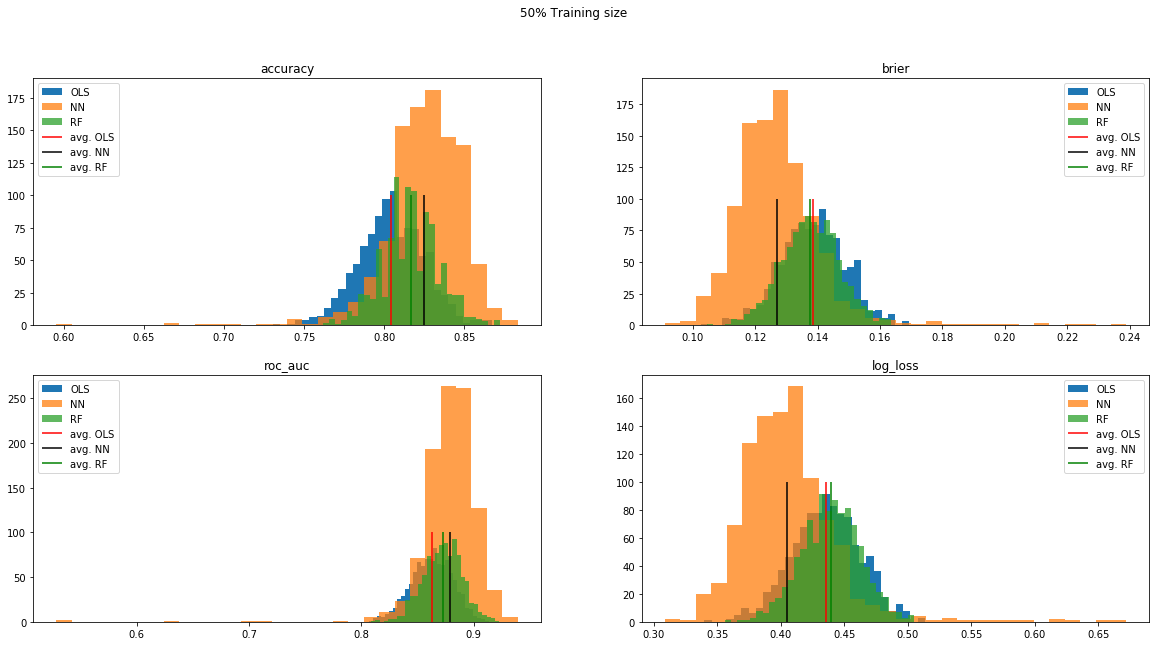

In [612]:
compareplots(train_df_0, train_df_mlp_0, train_df_rf_0, '50% Training size')

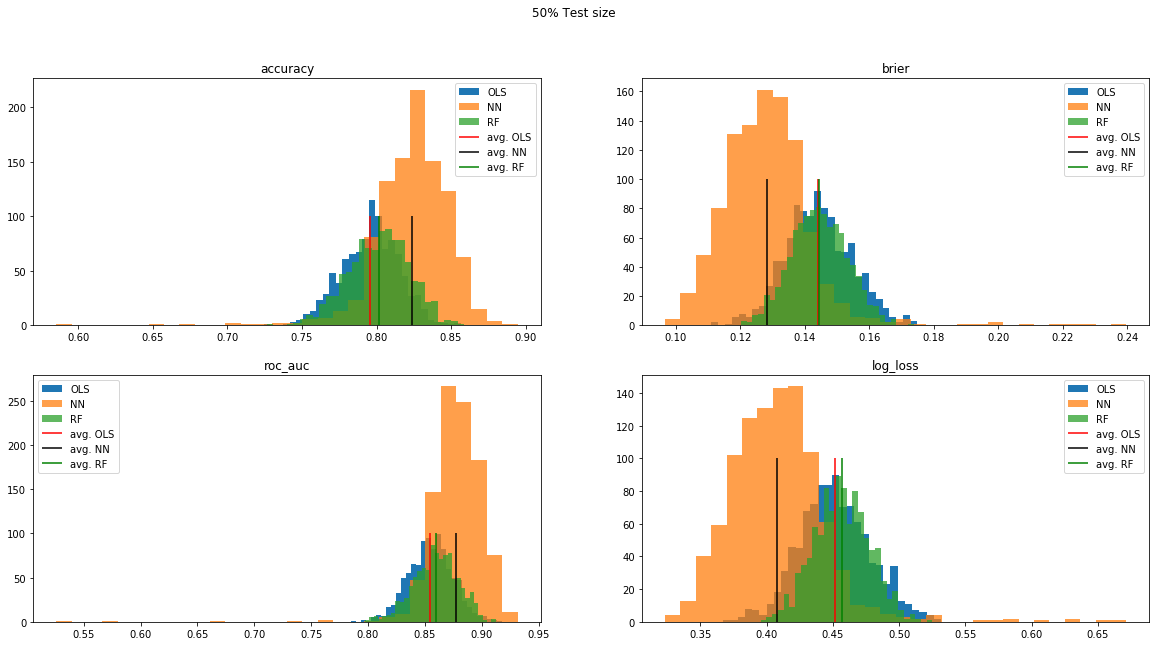

In [613]:
compareplots(test_df_0, test_df_mlp_0, test_df_rf_0, '50% Test size')

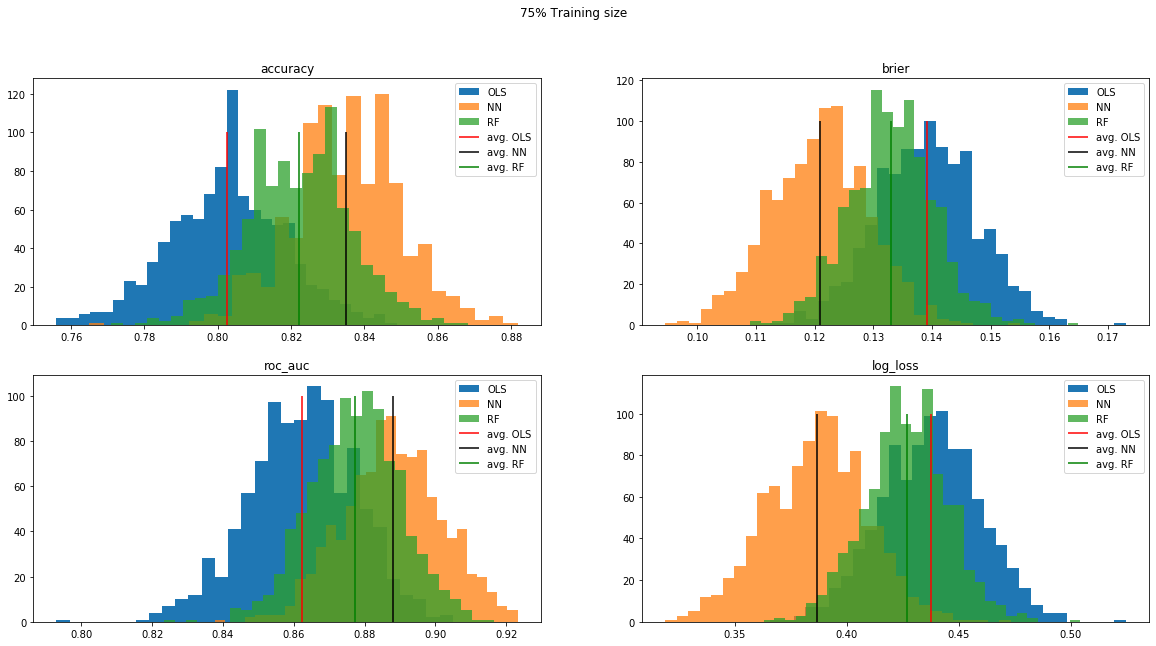

In [614]:
compareplots(train_df_1, train_df_mlp_1, train_df_rf_1, '75% Training size')

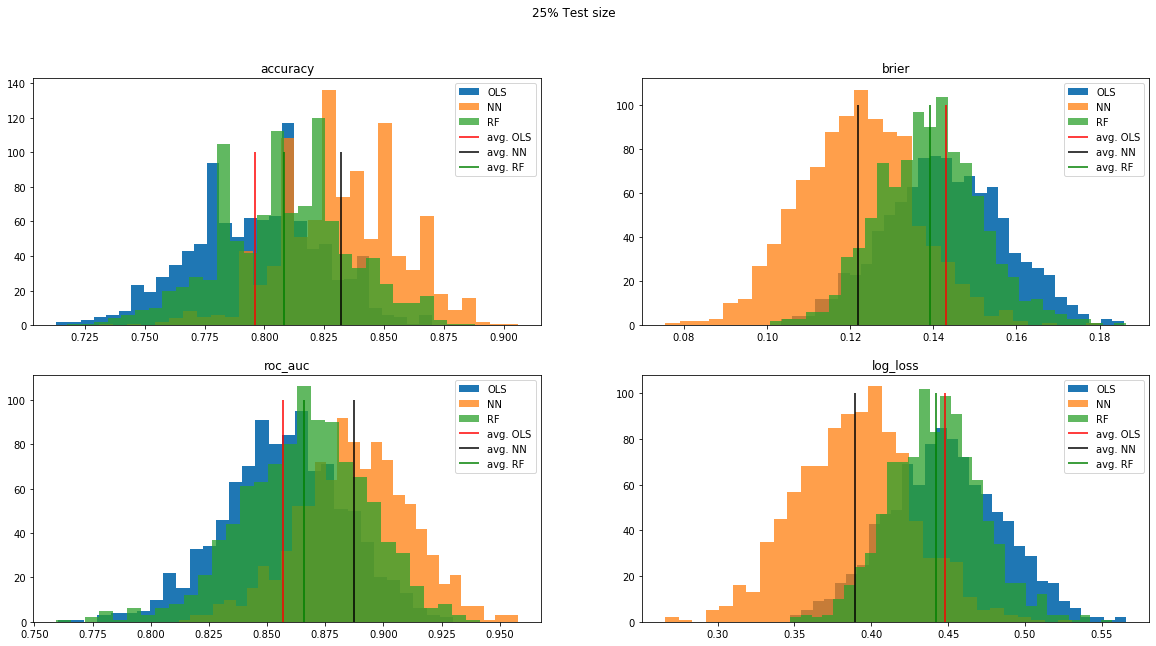

In [615]:
compareplots(test_df_1, test_df_mlp_1, test_df_rf_1, '25% Test size')

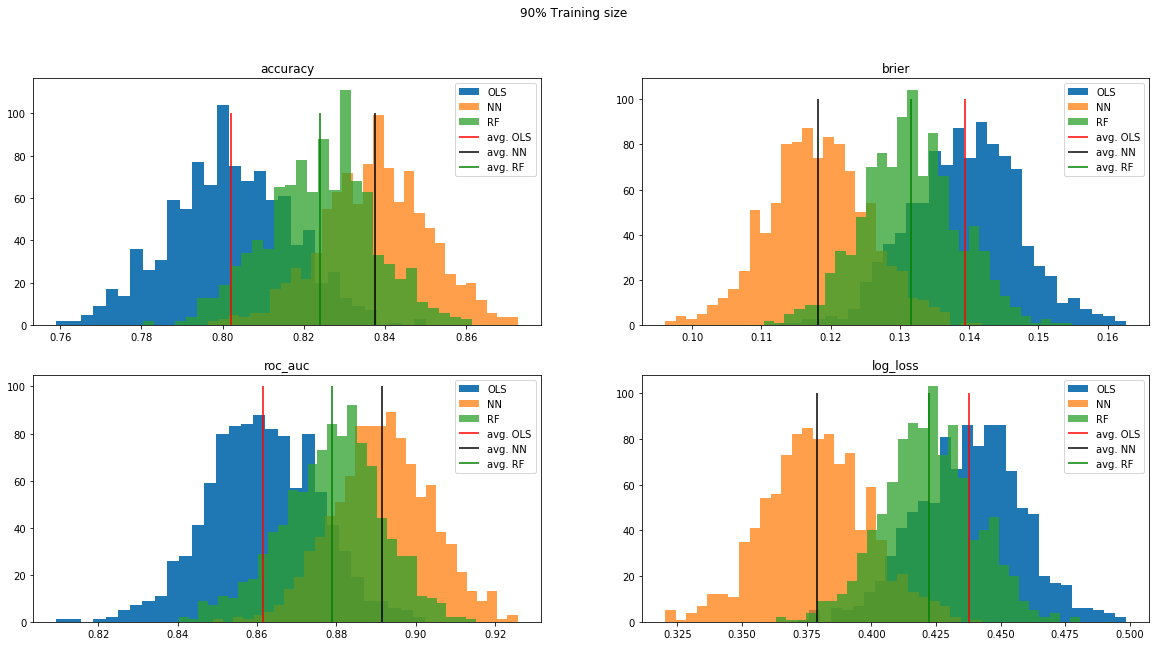

In [616]:
compareplots(train_df_2, train_df_mlp_2, train_df_rf_2, '90% Training size')

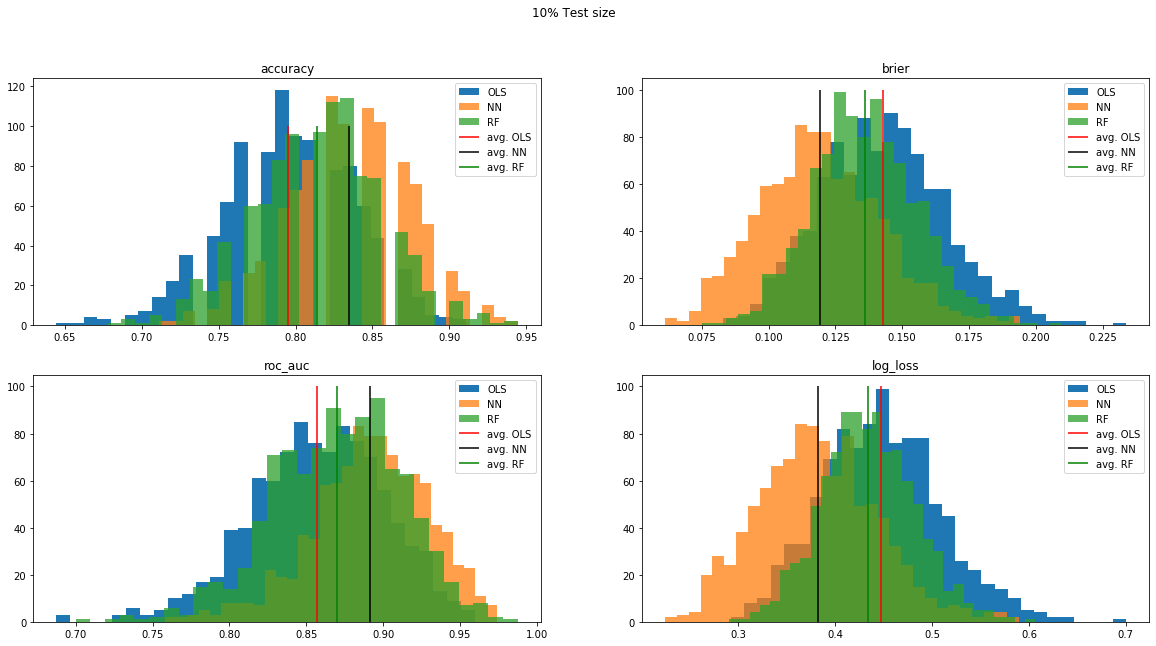

In [617]:
compareplots(test_df_2, test_df_mlp_2, test_df_rf_2, '10% Test size')

## Observations:
- We can see that in all the plots the MLP has outperformed both the Logisic Regression and the Random Forests for all training sizes based on the means of the distributions.

## Mean Tests across models

In [618]:
meantests(train_df_0,train_df_mlp_0, train_df_rf_0, 0.05)

,Metric,p,ANOVA Statistic,Different Means
0,accuracy,4.184593e-101,249.907380,YES
1,brier,2.726947e-122,307.762034,YES
2,roc_auc,6.177378e-60,142.728526,YES
3,log_loss,1.751131e-157,408.127315,YES


In [632]:
meantests(test_df_0,test_df_mlp_0, test_df_rf_0, 0.05)

,Metric,p,ANOVA Statistic,Different Means
0,accuracy,1.275381e-171,449.999795,YES
1,brier,1.079613e-247,691.610587,YES
2,roc_auc,8.719079e-118,295.302196,YES
3,log_loss,2.854776e-292,846.885613,YES


In [619]:
meantests(train_df_1,train_df_mlp_1, train_df_rf_1, 0.05)

,Metric,p,ANOVA Statistic,Different Means
0,accuracy,0.000000e+00,1209.432376,YES
1,brier,0.000000e+00,1357.972033,YES
2,roc_auc,1.156043e-297,866.400759,YES
3,log_loss,0.000000e+00,1616.187076,YES


In [633]:
meantests(test_df_1,test_df_mlp_1, test_df_rf_1, 0.05)

,Metric,p,ANOVA Statistic,Different Means
0,accuracy,1.158888e-177,468.172877,YES
1,brier,1.658356e-248,694.350282,YES
2,roc_auc,1.800041e-145,373.258521,YES
3,log_loss,2.032115e-293,851.025188,YES


In [620]:
meantests(train_df_2,train_df_mlp_2, train_df_rf_2, 0.05)

,Metric,p,ANOVA Statistic,Different Means
0,accuracy,0.0,1720.012890,YES
1,brier,0.0,2139.056381,YES
2,roc_auc,0.0,1387.770993,YES
3,log_loss,0.0,2509.970609,YES


In [634]:
meantests(test_df_2,test_df_mlp_2, test_df_rf_2, 0.05)

,Metric,p,ANOVA Statistic,Different Means
0,accuracy,3.420139e-93,228.778725,YES
1,brier,2.726471e-122,307.762244,YES
2,roc_auc,1.057848e-71,172.672048,YES
3,log_loss,3.848337e-145,372.309664,YES


## Mean Tests across training sizes

In [628]:
meantests(train_df_0, train_df_1, train_df_2, 0.05)

,Metric,p,ANOVA Statistic,Different Means
0,accuracy,0.012496,4.388726,YES
1,brier,0.144586,1.935132,NO
2,roc_auc,0.327324,1.117221,NO
3,log_loss,0.120788,2.115211,NO


In [629]:
meantests(test_df_0, test_df_1, test_df_2, 0.05)

,Metric,p,ANOVA Statistic,Different Means
0,accuracy,0.890365,0.116128,NO
1,brier,0.125899,2.073709,NO
2,roc_auc,0.188421,1.670005,NO
3,log_loss,0.086318,2.451726,NO


In [630]:
meantests(train_df_mlp_0, train_df_mlp_1, train_df_mlp_2, 0.05)

,Metric,p,ANOVA Statistic,Different Means
0,accuracy,3.804156e-55,130.694335,YES
1,brier,7.436875e-82,198.948578,YES
2,roc_auc,7.591396e-53,124.946498,YES
3,log_loss,3.237401e-97,239.491603,YES


In [631]:
meantests(test_df_mlp_0, test_df_mlp_1, test_df_mlp_2, 0.05)

,Metric,p,ANOVA Statistic,Different Means
0,accuracy,1.615012e-16,36.806782,YES
1,brier,1.185333e-30,70.516429,YES
2,roc_auc,3.128035e-25,57.499975,YES
3,log_loss,1.665134e-36,84.689827,YES


In [635]:
meantests(train_df_rf_0, train_df_rf_1, train_df_rf_2, 0.05)

,Metric,p,ANOVA Statistic,Different Means
0,accuracy,9.021906e-30,68.392725,YES
1,brier,1.168128e-68,164.875960,YES
2,roc_auc,2.304113e-23,53.041935,YES
3,log_loss,2.262029e-82,200.297318,YES


In [636]:
meantests(test_df_rf_0, test_df_rf_1, test_df_rf_2, 0.05)

,Metric,p,ANOVA Statistic,Different Means
0,accuracy,2.791714e-18,40.969944,YES
1,brier,2.772430e-38,89.022552,YES
2,roc_auc,1.202463e-13,30.046499,YES
3,log_loss,4.080962e-46,108.243415,YES


## Mean Tests:
- We first tried to test if the means of performance metrics for a given size are similar across the models or not. We found out out the means of the distributions of performance metrics to be different for all traing sizes and models. 
- Next we checked if the means of the performance metrics are sam across the training sizes for a given model. Here we have an interesting find that the means of performance metrics for the Logistic regression are same but for the other two models, we have different means across the training samples.

# Conclusion:
- Based on the analysis we performed on the performance metrics of the Classification Algorithms, we find that there is no converging distribution for the performance metrics of Test data. Where as the training metrics seem to converge to normal distribution.
- We saw that MLP outperformed other two models in terms of distribution of metrics that was centred around higher mean metrics compared to other models for all training sizes.
- Where as if we test for equality of means across the training sizes for all the models, the Logistic regression had same means for almost all performance metrics for all the training sizes but the other two did not. This might signal that the Logistic model performs more consistently in testing scenarios where as the MLP has the highest variance in performance metrics. This might be induced due to overfitting of the model or the higher complexity of the model for a simple classification problem.

END